In [40]:
from uncertainpy import Model

import numpy as np
from scipy.integrate import odeint


class HodgkinHuxley(Model):
    def __init__(self):
        Model.__init__(self,
                       interpolate=False,
                       labels=["Time (ms)", "Voltage (mV)"])

        ## HH Parameters
        self.V_rest = -65   # mV
        self.Cm = 1         # uF/cm**2
        self.gbar_Na = 120  # mS/cm**2
        self.gbar_K = 36    # mS/cm**2
        self.gbar_L = 0.3   # mS/cm**2
        self.E_Na = 50      # mV
        self.E_K = -77      # mV
        self.E_l = -54.4    # mV


        ## setup parameters and state variables
        self.I_value = 150
        T = 40    # ms
        dt = 0.025  # ms
        self.time = np.arange(0, T + dt, dt)



    def I(self, t):
        return self.I_value

    # K channel
    def alpha_n(self, V):
        return 0.01*(V + 55)/(1 - np.exp(-(V + 55)/10.))

    def beta_n(self, V):
        return 0.125*np.exp(-(V + 65)/80.)

    def n_f(self, n, V):
        return self.alpha_n(V)*(1 - n) - self.beta_n(V)*n

    def n_inf(self, V):
        return self.alpha_n(self.V_rest)/(self.alpha_n(self.V_rest) + self.beta_n(self.V_rest))


    # Na channel (activating)
    def alpha_m(self, V):
        return 0.1*(V + 40)/(1 - np.exp(-(V + 40)/10.))

    def beta_m(self, V):
        return 4*np.exp(-(V + 65)/18.)

    def m_f(self, m, V):
        return self.alpha_m(V)*(1 - m) - self.beta_m(V)*m

    def m_inf(self, V):
        return self.alpha_m(self.V_rest)/(self.alpha_m(self.V_rest) + self.beta_m(self.V_rest))


    # Na channel (inactivating)
    def alpha_h(self, V):
        return 0.07*np.exp(-(V + 65)/20.)

    def beta_h(self, V):
        return 1/(np.exp(-(V + 35)/10.) + 1)

    def h_f(self, h, V):
        return self.alpha_h(V)*(1 - h) - self.beta_h(V)*h

    def h_inf(self, V):
        return self.alpha_h(self.V_rest)/(self.alpha_h(self.V_rest) + self.beta_h(self.V_rest))


    def dXdt(self, X, t):
        V, h, m, n = X

        g_Na = self.gbar_Na*(m**3)*h
        g_K = self.gbar_K*(n**4)
        g_l = self.gbar_L

        dmdt = self.m_f(m, V)
        dhdt = self.h_f(h, V)
        dndt = self.n_f(n, V)

        dVdt = (self.I(t) - g_Na*(V - self.E_Na) - g_K*(V - self.E_K) - g_l*(V - self.E_l))/self.Cm

        return [dVdt, dhdt, dmdt, dndt]



    def run(self, **parameters):
        self.set_parameters(**parameters)

        self.h0 = self.h_inf(self.V_rest)
        self.m0 = self.m_inf(self.V_rest)
        self.n0 = self.n_inf(self.V_rest)

        initial_conditions = [self.V_rest, self.h0, self.m0, self.n0]
        
        X = odeint(self.dXdt, initial_conditions, self.time)
        
        values = X[:, 0]

         # Add info needed by certain spiking features and efel features
        info = {"stimulus_start": self.time[0], "stimulus_end": self.time[-1]}

        return self.time, values, info

In [41]:
import matplotlib.pyplot as plt
hh = HodgkinHuxley()
t0,v0,i0 = hh.run()
p = {'E_K':-76}
hh.set_parameters(**p)
t1,v1,i1 = hh.run()

In [42]:
i1

{'stimulus_end': 40.0, 'stimulus_start': 0.0}

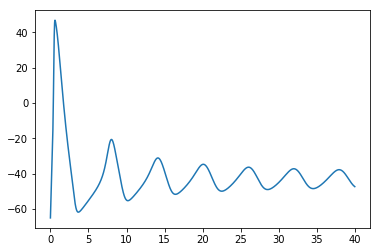

In [44]:
plt.plot(t0,v0)

In [4]:
import pyDOE
from scipy.stats.distributions import uniform

In [5]:
#Name, # Start of distribution, # Length of distribution
parameter_list = [["Cm",0.7,1.3-0.7],
                  ["gbar_Na", 80,160-80],
                  ["gbar_K", 26, 49-26],
                  ["gbar_L", 0.5, 0.5-0.13],
                  ["E_Na", 30, 54-30],
                  ["E_K", -79, -74-(-79)],
                  ["E_l", -61, -43-(-61)]]

In [6]:
parameter_list

[['Cm', 0.7, 0.6000000000000001],
 ['gbar_Na', 80, 80],
 ['gbar_K', 26, 23],
 ['gbar_L', 0.5, 0.37],
 ['E_Na', 30, 24],
 ['E_K', -79, 5],
 ['E_l', -61, 18]]

In [7]:
parameter_list = np.array(parameter_list)

In [8]:
aa = [float(n) for n in parameter_list[:,1]]

In [9]:
aa

[0.7, 80.0, 26.0, 0.5, 30.0, -79.0, -61.0]

In [10]:
ab = [float(n) for n in parameter_list[:,2]]

In [11]:
ab

[0.6000000000000001, 80.0, 23.0, 0.37, 24.0, 5.0, 18.0]

In [12]:
un = uniform(aa,ab)

In [13]:
lh = pyDOE.lhs(7,samples=3**7)

In [14]:
sample_space = un.ppf(lh)

In [15]:
names = list(parameter_list[:,0])

In [16]:
names

['Cm', 'gbar_Na', 'gbar_K', 'gbar_L', 'E_Na', 'E_K', 'E_l']

In [17]:
param_space = []
for ss in sample_space:
    pp = {names[i]:v for i,v in enumerate(ss)}
    param_space.append(pp)

In [18]:
%%time
voltages = []
for pdict in param_space:
    hh = HodgkinHuxley()
    hh.set_parameters(**pdict)
    t,v,i = hh.run()
    voltages.append(v)
    

CPU times: user 2min 20s, sys: 897 ms, total: 2min 21s
Wall time: 2min 23s


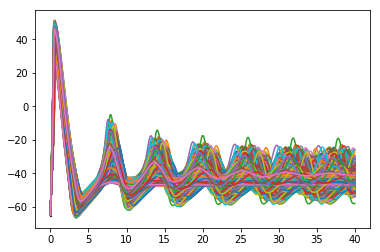

In [19]:
plt.plot(t,np.transpose(voltages));

In [66]:
vv = np.array(voltages)

In [67]:
ind = []
for v in vv:
    for i,vo in enumerate(v):
        if vo > 0:
            ind.append(i)
            break


In [68]:
np.mean(ind)*0.025

0.4115340649291267

In [69]:
import pandas as pd

In [70]:
col_names = [str(round(tt,3)) for tt in t0]

In [71]:
voltage_data = pd.DataFrame(voltages,columns=col_names)

In [72]:
voltage_data.head()

,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,...,14.775,14.8,14.825,14.85,14.875,14.9,14.925,14.95,14.975,15.0
0,-65.0,-61.440481,-57.963059,-54.562770,-51.233731,-47.967881,-44.753316,-41.572053,-38.397154,-35.189267,...,-41.613800,-41.586280,-41.561422,-41.539281,-41.519909,-41.503356,-41.489669,-41.478894,-41.471073,-41.466248
1,-65.0,-61.170429,-57.446835,-53.821992,-50.287254,-46.830839,-43.435557,-40.075791,-36.713713,-33.294891,...,-36.079704,-36.210892,-36.347129,-36.488214,-36.633946,-36.784119,-36.938524,-37.096951,-37.259190,-37.425027
2,-65.0,-61.665397,-58.391871,-55.173871,-52.004428,-48.873704,-45.767028,-42.662204,-39.525912,-36.309052,...,-36.264400,-36.592620,-36.916816,-37.236913,-37.552845,-37.864551,-38.171976,-38.475068,-38.773779,-39.068060
3,-65.0,-60.152175,-55.430290,-50.824502,-46.321664,-41.901405,-37.530561,-33.155802,-28.695129,-24.030253,...,-40.397674,-40.521466,-40.644656,-40.767130,-40.888779,-41.009494,-41.129172,-41.247709,-41.365006,-41.480967
4,-65.0,-61.230211,-57.564828,-53.998063,-50.523192,-47.131255,-43.809320,-40.538208,-37.289632,-34.022907,...,-41.614361,-41.646053,-41.680961,-41.719073,-41.760374,-41.804847,-41.852466,-41.903203,-41.957027,-42.013900


In [73]:
voltage_data.to_csv("/Users/larserikodegaard/../../Volumes/LE/Mas300/_data/HH_voltage.csv")

In [74]:
aa

[0.7, 80.0, 26.0, 0.5, 30.0, -79.0, -61.0]

In [75]:
param_space

[{'Cm': 1.0991683872465374,
  'E_K': -74.69874939234784,
  'E_Na': 45.511610896740194,
  'E_l': -43.30344520493059,
  'gbar_K': 48.98025299543974,
  'gbar_L': 0.5532761875779704,
  'gbar_Na': 123.95408828146313},
 {'Cm': 1.014480881080503,
  'E_K': -74.81689837472922,
  'E_Na': 38.85539211719515,
  'E_l': -53.012587253297234,
  'gbar_K': 34.52812258050881,
  'gbar_L': 0.8172304105818635,
  'gbar_Na': 141.80673527961545},
 {'Cm': 1.1587658835756889,
  'E_K': -74.86135991021712,
  'E_Na': 52.85253000660757,
  'E_l': -53.33179805003533,
  'gbar_K': 27.775468398247586,
  'gbar_L': 0.6166370590165885,
  'gbar_Na': 158.53452398935127},
 {'Cm': 0.8092179673695219,
  'E_K': -74.96137505576468,
  'E_Na': 36.27449399449518,
  'E_l': -45.04494089632351,
  'gbar_K': 31.770097075614828,
  'gbar_L': 0.5554862854531634,
  'gbar_Na': 133.29645038710441},
 {'Cm': 1.0122121113744134,
  'E_K': -78.91408179625608,
  'E_Na': 42.31890239975552,
  'E_l': -52.61820109950773,
  'gbar_K': 39.36415279553487,
  '

In [80]:
foo = param_space[0]

In [96]:
parameter_space = []
for p in param_space:
    parameter_space.append(list(p.values()))
    
parameter_space = np.array(parameter_space)

In [97]:
parameter_df = pd.DataFrame(parameter_space,columns=names)